In [8]:
!pip3 install requests beautifulsoup4 lxml

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
import requests
from bs4 import BeautifulSoup

base_url = 'https://blog.gov.bc.ca/bcwildfire/page/'
news_links = []


for page in range(1, 30):
    url = f'{base_url}{page}'
    
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to retrieve page {page}")
        break

    soup = BeautifulSoup(response.text, 'lxml')
    articles = soup.find_all('div', class_='post-feed-box')

    for article in articles:
        link = article.find('h1').find('a')['href']
        news_links.append(link)

In [10]:
from datetime import datetime

def convert_to_timestamp(date_str, date_format):
    date_obj = datetime.strptime(date_str, date_format)
    timestamp = int(date_obj.timestamp())
    return timestamp

In [11]:
import pandas as pd

df = pd.DataFrame({"title": [], "date": [], "content": [], "link": []})

for link in news_links:
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'lxml')
    title = soup.find('h1', class_="entry-title").text
    date = soup.find('time').text
    content = soup.find('div', class_='entry-content').text
    df.loc[len(df)] = {"title": title, "created_at": convert_to_timestamp(
        date, "%B %d, %Y"), "content": content, "link": link}


In [12]:
df.to_csv('bc_wildfire_news.csv', index=False)

In [13]:
import emoji
import re

def clean_text(text):
    if not isinstance(text, str): return " "
    text = text.lower()
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [22]:
df = pd.read_csv('bc_wildfire_news.csv')
df['clean_content'] = df['content'].apply(clean_text)
df = df[df['created_at'] >= 1677654056]
df

,title,created_at,content,link,clean_content
0,Campfire Prohibition Partially Rescinded in No...,1694498400,\nSMITHERS – Effective at 12:00 p.m. (noon) on...,https://blog.gov.bc.ca/bcwildfire/cat1-partial...,smithers – effective at 12:00 p.m. (noon) on ...
1,Forecasted weather conditions expected to incr...,1694325600,\nPRINCE GEORGE – Weather conditions across th...,https://blog.gov.bc.ca/bcwildfire/forecasted-w...,prince george – weather conditions across the...
2,Area restriction for the Jubilee Mountain wild...,1694152800,\nCASTLEGAR– Effective immediately the Area Re...,https://blog.gov.bc.ca/bcwildfire/area-restric...,castlegar– effective immediately the area res...
3,Area Restriction implemented for Casper Creek ...,1694152800,\nKAMLOOPS – The BC Wildfire Service has imple...,https://blog.gov.bc.ca/bcwildfire/area-restric...,kamloops – the bc wildfire service has implem...
4,Area Restriction expanded for the Downton Lake...,1694152800,\nKAMLOOPS – The BC Wildfire Service has expan...,https://blog.gov.bc.ca/bcwildfire/area-restric...,kamloops – the bc wildfire service has expand...
...,...,...,...,...,...
188,Pile burns planned for Mill Creek Quarry site,1679637600,\nFORT NELSON—The BC Wildfire Service plans to...,https://blog.gov.bc.ca/bcwildfire/pile-burns-p...,fort nelson—the bc wildfire service plans to ...
189,Prescribed burn scheduled for Chu Chua,1679378400,\nKAMLOOPS – The BC Wildfire Service and Simpc...,https://blog.gov.bc.ca/bcwildfire/prescribed-b...,kamloops – the bc wildfire service and simpcw...
190,Pile burning in Myra Bellevue Park,1678431600,"\nKELOWNA – The BC Wildfire Service, in conjun...",https://blog.gov.bc.ca/bcwildfire/pile-burning...,"kelowna – the bc wildfire service, in conjunc..."
191,Prescribed burns scheduled for the Lytton Area,1678431600,"\nLYTTON – The BC Wildfire Service, Lytton Fir...",https://blog.gov.bc.ca/bcwildfire/prescribed-b...,"lytton – the bc wildfire service, lytton firs..."


time
2023-03-06    1
2023-03-10    2
2023-03-21    1
2023-03-24    1
2023-03-27    1
             ..
2023-09-05    4
2023-09-07    3
2023-09-08    4
2023-09-10    1
2023-09-12    1
Length: 101, dtype: int64


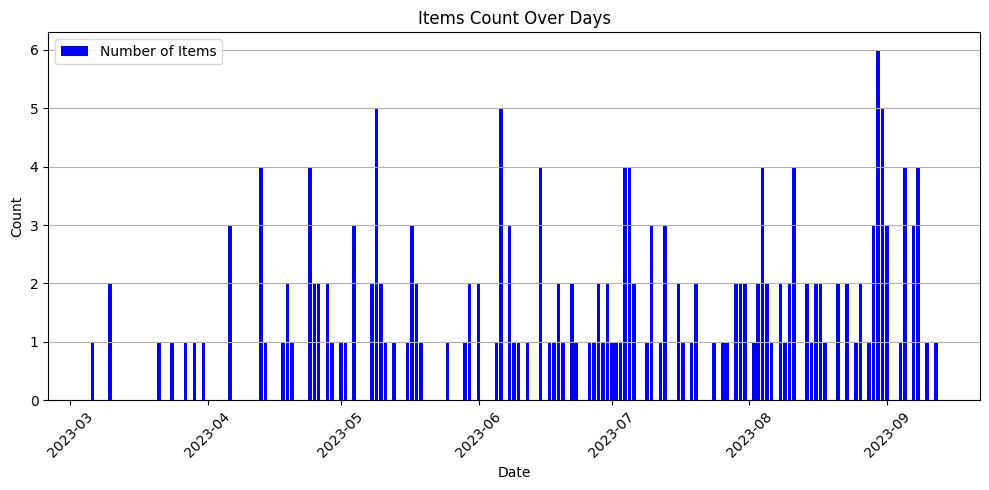

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df['time'] = pd.to_datetime(df['created_at'], unit='s')

daily_counts = df.groupby(df['time'].dt.date).size()
print(daily_counts)

plt.figure(figsize=(10, 5))
plt.bar(daily_counts.index, daily_counts, label='Number of Items', color='blue', width=0.8)

plt.title('Items Count Over Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import pandas as pd
import random

nltk.download('stopwords')
nltk.download('punkt')


def topic_mining(selected_rows):
    texts = selected_rows['title'].tolist()

    stop_words = set(stopwords.words('english'))

    preprocessed_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        filtered_words = [word for word in tokens if word.isalpha() and word not in stop_words]
        preprocessed_texts.append(filtered_words)


    dictionary = corpora.Dictionary(preprocessed_texts)
    corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


    num_topics = 5
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)

    for topic_id in range(num_topics):
        topic_keywords = lda_model.show_topic(topic_id, topn=10)
        keyword_list = [keyword for keyword, _ in topic_keywords]
        print(f"Topic {topic_id + 1}: {', '.join(keyword_list)}")

        doc_topics = lda_model.get_document_topics(corpus)

        relevant_docs = [texts[i] for i, topics in enumerate(doc_topics) if any(topic[0] == topic_id for topic in topics)]

        print("Examples:")
        for doc in random.sample(relevant_docs, k=min(5, len(relevant_docs))):
            print(doc)
        print()

topic_mining(df)

/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Topic 1: fire, centre, prohibition, category, planned, campfire, open, burn, cariboo, burning
Examples:
Wind warning issued for part of the Northwest Fire Centre
Provincial Wildfire Status Update – August 14, 2023
Open Burning 101 – Category 1 Campfires
Area restriction in effect for Kamma Creek
Category 2 burning to be prohibited in the Southeast

Topic 2: area, restriction, burn, effect, vicinity, creek, planned, prescribed, rescinded, burning
Examples:
Provincial Wildfire Status Update – May 18, 2023
Pile burning scheduled near Heffley Creek
Prescribed burn planned for Fox Mountain
Category 1 campfire prohibitions rescinded throughout the Cariboo
Area Restriction in effect for St. Mary’s River Wildfire

Topic 3: wildfire, update, provincial, status, fire, august, centre, june, campfire, george
Examples:
Campfire prohibition rescinded in Prince George and Northwest Fire Centres
Provincial Wildfire Status Update – June 1, 2023
All open fire prohibited in Prince George Fire Centre
Area

In [35]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and not word.isdigit()]
    clean_text = ' '.join(filtered_words)
    clean_text = clean_text.lower()
    clean_text = re.sub(r'http\S+|www\S+', '', clean_text)
    clean_text = re.sub(r'@\S+', '', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text)
    return clean_text



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
tfidf_vectorizer = TfidfVectorizer(max_features=20)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['title'].apply(clean_text))

feature_names = tfidf_vectorizer.get_feature_names_out()

average_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

term_tfidf_pairs = list(zip(feature_names, average_tfidf_scores))

sorted_terms = sorted(term_tfidf_pairs, key=lambda x: x[1], reverse=True)

top_keywords = [term for term, score in sorted_terms]

print("Top Keywords:")
print(top_keywords)

Top Keywords:
['wildfire', 'area', 'restriction', 'fire', 'creek', 'update', 'provincial', 'status', 'centre', 'rescinded', 'effect', 'burn', 'planned', 'category', 'campfire', 'prohibition', 'prescribed', 'burning', 'cariboo', 'vicinity']


In [37]:
tfidf_vectorizer = TfidfVectorizer(max_features=20)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['content'].apply(clean_text))

feature_names = tfidf_vectorizer.get_feature_names_out()

average_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

term_tfidf_pairs = list(zip(feature_names, average_tfidf_scores))

sorted_terms = sorted(term_tfidf_pairs, key=lambda x: x[1], reverse=True)

top_keywords = [term for term, score in sorted_terms]

print("Top Keywords:")
print(top_keywords)

Top Keywords:
['wildfire', 'fire', 'bc', 'area', 'open', 'burning', 'service', 'creek', 'public', 'lake', 'may', 'order', 'conditions', 'wildfires', 'campfire', 'centre', 'road', 'information', 'facebook', 'twitter']
